# P1D Mock - Old

This is an initial test for creating P1D mocks, using largely the methods in Naim's 2020 paper, " Optimal 1D Lyα forest power spectrum estimation– I. DESI-lite spectra."

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
import scipy.linalg as la

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

from numpy.polynomial.hermite import hermgauss

## Gaussian Random Grid

 (i)  Generate a long, high-resolution Gaussian random grid with equal spacing in velocity v, zero mean, and unit variance.

In [2]:
seed = 10 # for repeatability
# size = 2**20
size = 2**12
c = 299792.458  # speed of light in km/s
lambda_0 = 1216  # rest wavelength in Angstroms (for Lyα)

def lambda_c(z, lambda_0 = 1216):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

mean (velocity-space):   -0.034746765164638455
stdev (velocity-space):   0.9980494560028187
shape:  (4096,)
seed:   10


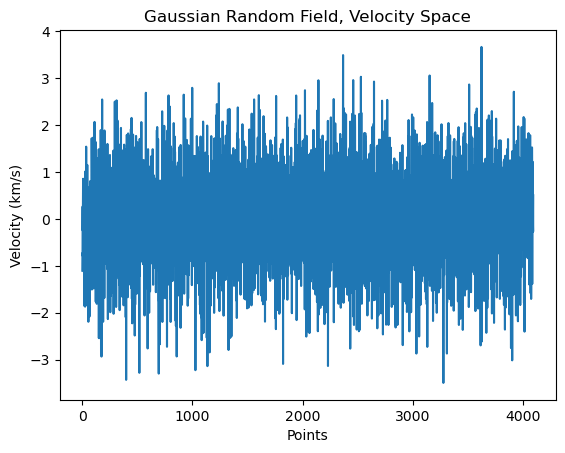

In [3]:
# Generate Gaussian random field in velocity-space
gaussian_random_field = np.random.default_rng(seed).normal(size=size)

plt.plot(gaussian_random_field)
plt.title('Gaussian Random Field, Velocity Space')
plt.xlabel('Points')
plt.ylabel('Velocity (km/s)')

# print("mean:  " + str(gaussian_random_field.mean()))
# print("stdev:  " + str(gaussian_random_field.std()))
# print("shape: " + str(gaussian_random_field.shape))
# print("seed :  " + str(seed))

# Check properties
print("mean (velocity-space):  ", gaussian_random_field.mean())
print("stdev (velocity-space):  ", gaussian_random_field.std())
print("shape: ", gaussian_random_field.shape)
print("seed:  ", seed)

## FFT Transformation

 (ii) FFT the grid, and multiply with $\sqrt{P(k) / dv}$ to obtain $ \tilde{\delta}_b(k) $, where dv is the grid spacing in velocity units and the power spectrum is: 
 
\begin{align}
P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}} \tag{20}\\
\end{align}

Where, $k_0 = 0.001 s km^{-1}$, $ k_1 = 0.04 s km^{-1}$, $ n = 0.5 $, $ \alpha = 0.26$, and $\gamma = 1.8$ 

Inverse FFT and save the variance of this grid, $\sigma^2$. This is a crude Gaussian base for baryon fluctuations, $\delta_b(v)$, with defined power spectrum at $z_0 = 3$.

### FFT on grid

gaussian field k-space shape: (2049,)


Text(0, 0.5, 'Amplitude')

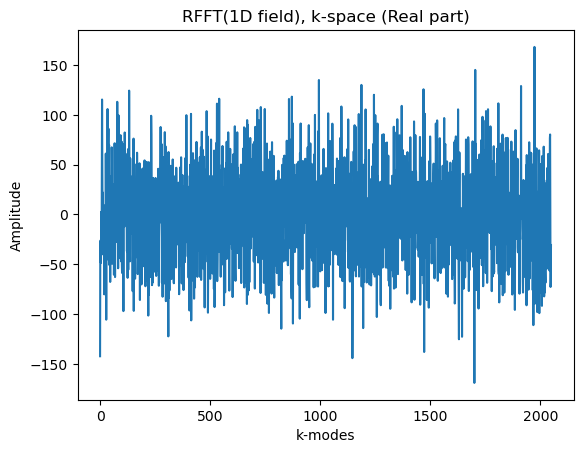

In [4]:
# Compute the FFT to get the field in k-space

gaussian_random_field_k = np.fft.rfft(gaussian_random_field) # normalization ?
print('gaussian field k-space shape: ' + str(gaussian_random_field_k.shape))
# note how the shape changes because only real portion

# # Normalize the k-space field
# normalization_factor = 1 / np.sqrt(size)
# gaussian_random_field_k = gaussian_random_field_k * normalization_factor

# # Compute the FFT to get the field in k-space
# gaussian_random_field_k = np.fft.rfft(gaussian_random_field)
# gaussian_random_field_k /= size  # Normalize using size for energy conservation


plt.plot(np.real(gaussian_random_field_k)) # plot only real part of fft
plt.title('RFFT(1D field), k-space (Real part)')
plt.xlabel('k-modes')
plt.ylabel('Amplitude')

### Make grid of k-modes

In [5]:
# make a grid of k-modes, using same dims as gaussian field
# d = spacing of the grid

kmodes = (np.fft.rfftfreq(n=size, d=1) * 2 * np.pi) + 1e-12 # factor of 2pi
print('Number of kmodes: '+ str(kmodes.size))

print(kmodes)

Number of kmodes: 2049
[1.00000000e-12 1.53398079e-03 3.06796158e-03 ... 3.13852469e+00
 3.14005867e+00 3.14159265e+00]


### Measure power

$$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $$

In [6]:
def measure_power(array):
    power = np.abs(array)**2
    return(power)

def measure_scaled_power(array, n, length_scale):
    power = np.abs(array)**2
    scaled_power = power / (n * length_scale)
    return(scaled_power)

Text(0, 0.5, '$ P(k) = \\langle|\\tilde{\\delta(k)}|^2 \\rangle $')

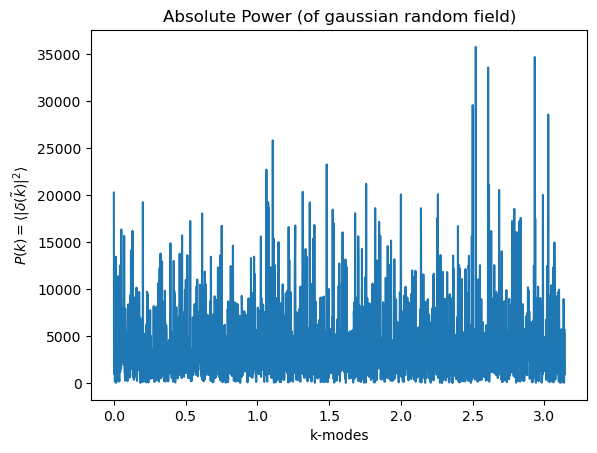

In [7]:
plt.plot(kmodes,measure_power(gaussian_random_field_k))
plt.title('Absolute Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel(r'$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $')

# cannot average across realizations, average across kbins, st each bin has mult. modes (e.g. 8-10 modes)

Text(0, 0.5, 'P(k) / L')

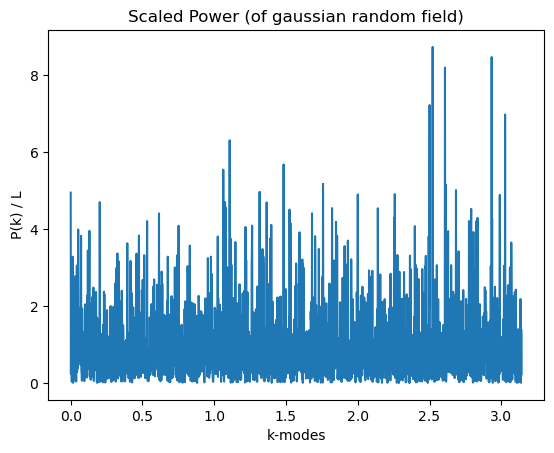

In [8]:
plt.plot(kmodes,measure_scaled_power(gaussian_random_field_k, n = size ,length_scale=1))
plt.title('Scaled Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel('P(k) / L')


#### Rebinning k-modes

In [9]:
statistic, bin_edges, binnumber = binned_statistic(x = kmodes, values = 
                                                   measure_scaled_power(gaussian_random_field_k, 
                                                    n=size, length_scale=1), 
                                                    statistic = 'mean', bins=40)

In [10]:
print(statistic.shape) # The values of the selected statistic in each bin, mean here
print(bin_edges.shape) # Return the bin edges (length(statistic)+1).
print(binnumber.shape) # Indices of the bins (corresponding to bin_edges) 
                       # in which each value of x belongs. Same length as values 

(40,)
(41,)
(2049,)


Text(0.5, 0, 'k-bins')

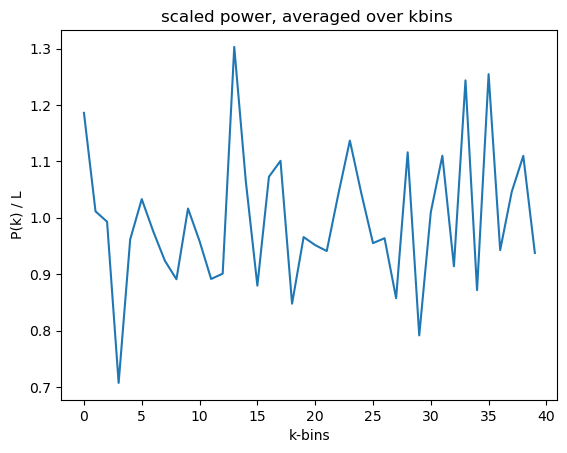

In [11]:
plt.plot(statistic)
plt.title('scaled power, averaged over kbins ')
plt.ylabel('P(k) / L')
plt.xlabel('k-bins')

### Power Spectrum Factor

In [12]:
def power_spectrum(k, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):  #kmodes 
    pk = ( (k / k0)**(n - alpha * np.log(k / k0)) ) / (1 + (k / k1)**gamma)
    pk_i = np.arange(len(pk))
    
    mask = np.isfinite(pk)
    pk_filtered=np.interp(pk_i, pk_i[mask], pk[mask])
    return(pk_filtered)

(-0.01, 0.3)

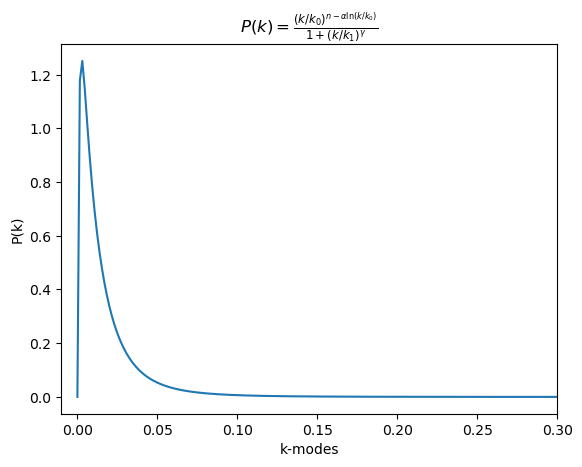

In [13]:
plt.plot(kmodes,power_spectrum(kmodes))
plt.title(r'$P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$')
plt.xlabel('k-modes')
plt.ylabel('P(k)')
plt.xlim([-0.01,0.3])

Text(0, 0.5, 'P(k)')

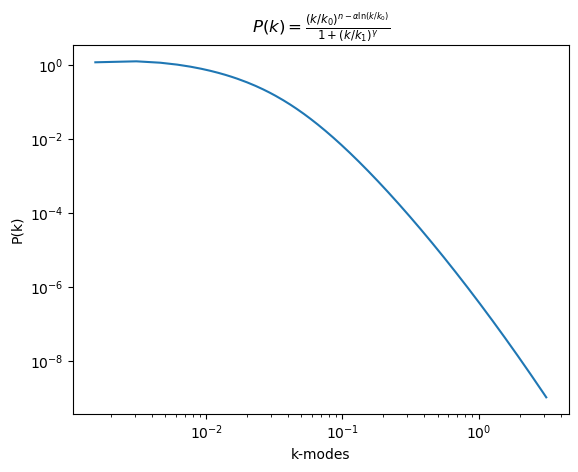

In [14]:
plt.loglog(kmodes[1:],power_spectrum(kmodes[1:]), color='tab:blue')
plt.title(r'$P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$')
plt.xlabel('k-modes')
plt.ylabel('P(k)')
# plt.xlim([-0.01,0.3])

Multiply rfft(gaussian_random_grid) with $\sqrt{P(k) / dv}$ to obtain $ \tilde{\delta}_b(k) $, where dv is the grid spacing in velocity units and the power spectrum is: 
 
\begin{align}
P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}\tag{20}\\
\end{align}

In [15]:
def delta_transform(k_field, kmodes, dv=1, k0=0.001, k1 = 0.04, n=0.5, alpha=0.26, gamma=1.8):
    delta_b_tilde = k_field * np.sqrt(power_spectrum(kmodes,k0,k1,n,alpha,gamma) / dv)  # multiply k-space field by p(k) expression above
    delta_b = np.fft.irfft(delta_b_tilde)             # inverse rfft back to v-space
    return(delta_b)

Text(0, 0.5, '$\\tilde\\delta_b(k)$')

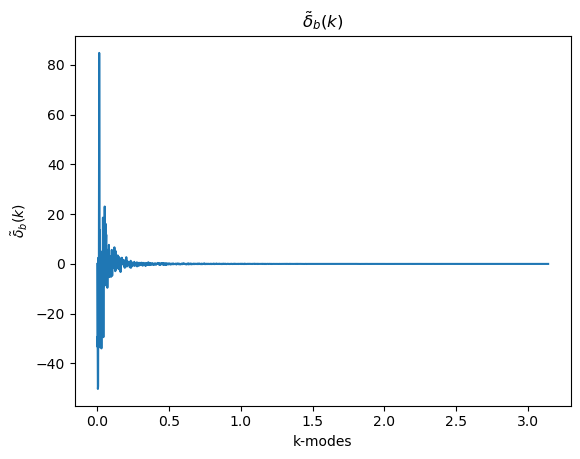

In [16]:
plt.plot(kmodes, np.real(gaussian_random_field_k * np.sqrt(power_spectrum(kmodes) / 1)))
plt.title(r"$\tilde\delta_b(k)$")
plt.xlabel('k-modes')
plt.ylabel(r"$\tilde\delta_b(k)$")

variance: 0.006696531119928552


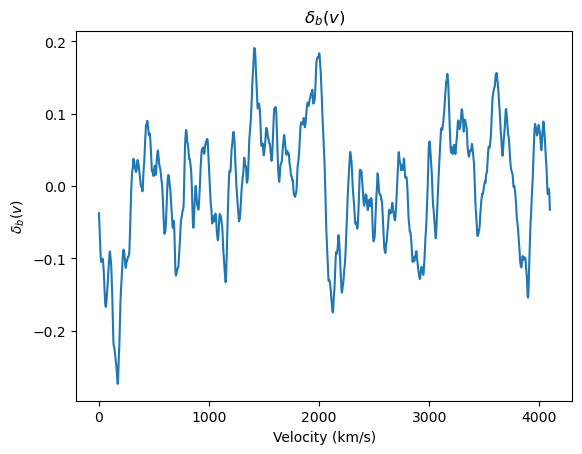

In [17]:
plt.plot(delta_transform(gaussian_random_field_k, kmodes, dv=1))
plt.title(r"$\delta_b(v)$")
plt.ylabel(r"$\delta_b(v)$")
plt.xlabel('Velocity (km/s)')# plt.ylabel(r"$\delta_b(v)$")

print('variance: ' + str(delta_transform(gaussian_random_field_k, kmodes, dv=1).var()))

In [18]:
delta_b_v = delta_transform(k_field = gaussian_random_field_k, kmodes=kmodes, dv=1)

variance_1d = delta_b_v.var() # sigma^2

## Redshift Evolution Factor

(iii) Multiply with a redshift evolution factor $a(z)$, such that, $\delta_b(z) = a(z)\delta_b(v)$ and $\sigma^2(z) = a^2(z)\sigma^2(v)$

\begin{align}
a^2(z) = 58.6 (\frac{1+z}{1+z_0})^{-2.82} \tag{21}\\
\end{align}

Let a = 58.6, and b = -2.82

In [19]:
def redshift_evolution(z, z0=3, a=58.6, b=-2.82):
    a_z = np.sqrt(a * (((1+z)/(1+z0))**(b)))    
    return(a_z)

In [20]:
delta_b_z = delta_b_v * redshift_evolution(z=2.8,z0=3)
redshifted_variance_1d = variance_1d * redshift_evolution(z=2.8,z0=3)**2

Text(0.5, 0, 'Velocity (km/s)')

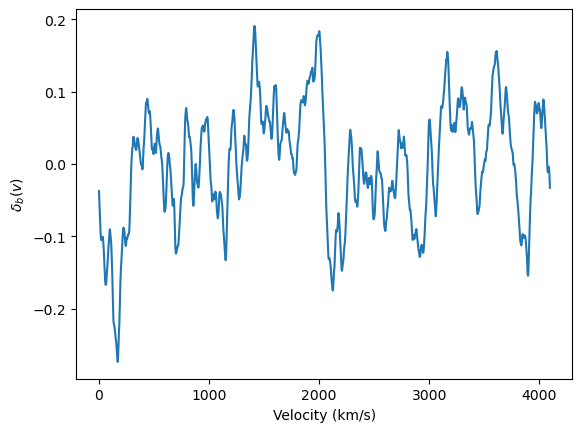

In [35]:
plt.plot(delta_b_v)
plt.ylabel(r'$\delta_b(v)$')
plt.xlabel('Velocity (km/s)')
# plt.xlim([0,1000])
# plt.title(r'$\delta_b(z) = a(z)\delta_b$ @ $z=2.8, z_0=3$')

Text(0.5, 1.0, '$\\delta_b(z) = a(z)\\delta_b$ @ $z=2.8, z_0=3$')

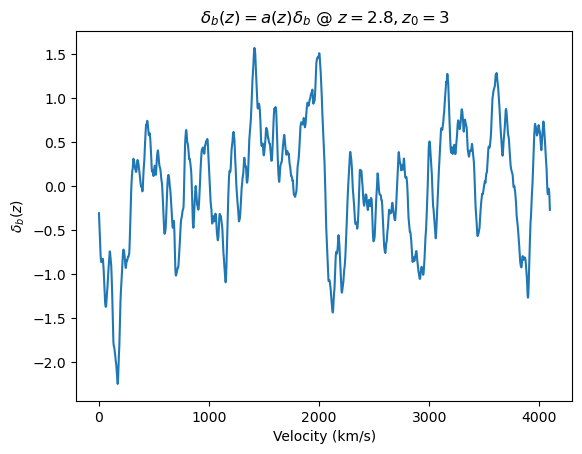

In [36]:
plt.plot(delta_b_v * redshift_evolution(z=2.8,z0=3))
plt.ylabel(r'$\delta_b(z)$')
plt.xlabel('Velocity (km/s)')
# plt.xlim([0,1000])
plt.title(r'$\delta_b(z) = a(z)\delta_b$ @ $z=2.8, z_0=3$')

## Lognormal Transformation


(iv) Apply a squared lognormal transformtation to approximate the non-linear and non-Gaussian HI column density field:

\begin{align}
n(z) = e^{2\delta_b(z)-\sigma^2(z)}  \tag{22}\\
\end{align}

In [22]:
def lognormal_transform(delta_z, variance):
    n_z = np.exp( (2 * (delta_z) - (variance)))
    return(n_z)

Text(0.5, 0, 'Velocity (km/s)')

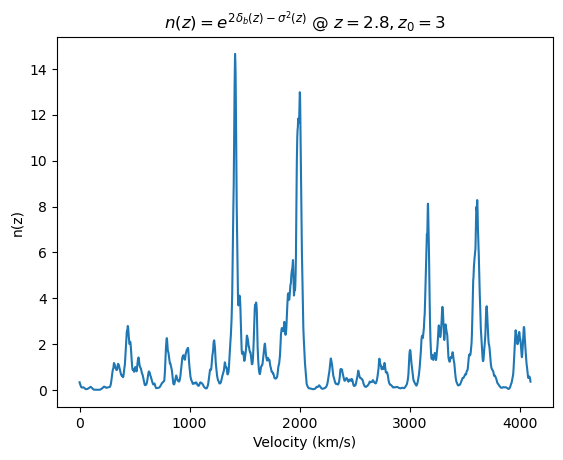

In [23]:
plt.plot(lognormal_transform(delta_b_z, redshifted_variance_1d))
plt.title(r'$n(z) = e^{2 \delta_b (z) - \sigma^2(z)}$ @ $z=2.8, z_0 = 3$')
plt.ylabel('n(z)')
plt.xlabel('Velocity (km/s)')
# plt.xlabel('v-space')

## Optical Depth Transformation

(v) Transform this to optical depth $\tau$ by multiplying with another redshift-dependent function:

\begin{align}
\tau(z) = 0.55 (\frac{1+z}{1+z_0})^{5.1} n(z)   \tag{23}\\
\end{align}

In [24]:
def optical_depth_transform(n_z, z=2.8, z0=3, c=0.55, d=5.1):
    tau_z = c * (((1+z)/(1+z0))**d) * n_z
    return(tau_z)

Text(0.5, 0, 'Velocity (km/s)')

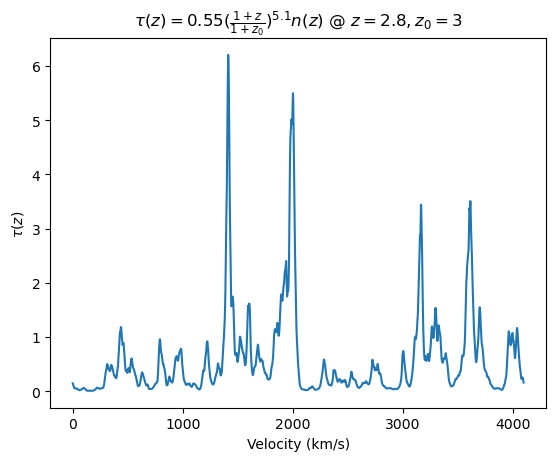

In [25]:
plt.plot(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d), z=2.8))
plt.title(r'$\tau(z) = 0.55 (\frac{1+z}{1+z_0})^{5.1} n(z)$ @ $z=2.8, z_0 = 3$')
plt.ylabel(r'$\tau(z)$')
plt.xlabel('Velocity (km/s)')

# plt.xlabel('v-space')

## Smoothing / Flux

(vi) Finally, the flux is: $ F(z) = e^{-\tau(z)} $

In [26]:
def flux(tau):
    F_z = np.exp(-(tau))
    return(F_z)

Text(0.5, 0, 'Velocity (km/s)')

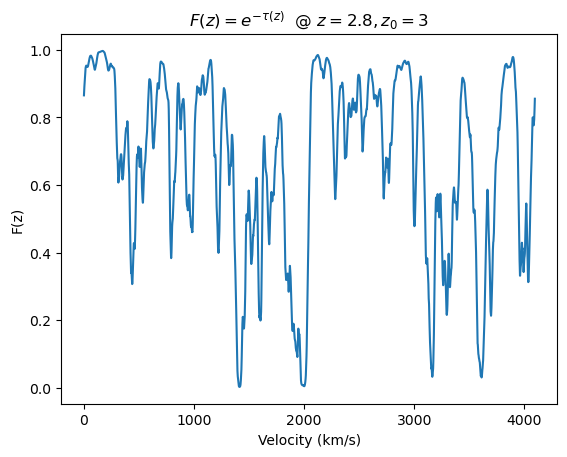

In [27]:
plt.plot(flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))[:10000])
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.ylabel('F(z)')
plt.xlabel('Velocity (km/s)')

# plt.xlabel('v-space')



Text(0.5, 0, 'Velocity (km/s)')

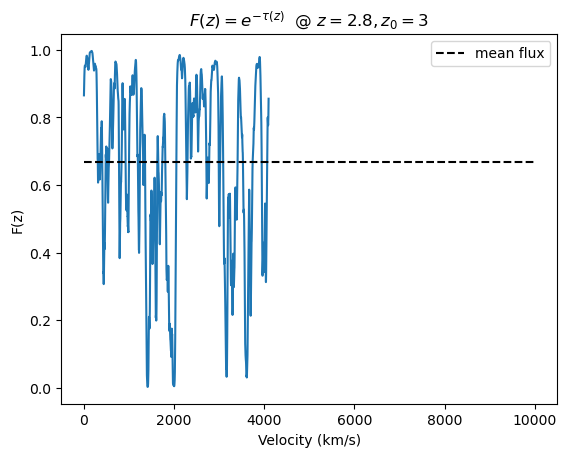

In [28]:
plt.plot(flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))[:10000])
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.ylabel('F(z)')
plt.hlines(y=flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d))).mean(), xmin=0,xmax=10000, color='black', ls='--',label='mean flux')
plt.legend()
plt.xlabel('Velocity (km/s)')


#### Transform to wavelength space

$$ v = c \ln(\lambda/\lambda_{pivot}) $$

where, 

$$ \lambda_{pivot} = (1+z_{pivot}) \lambda_{Ly\alpha} $$

and $\lambda_{Ly\alpha} = 1215.67 \dot{A} $. 

So, need to plot flux against the wavelngth grid, given by, 

$$ \lambda = \lambda_{pivot} \exp[(v - v_0) /c] $$

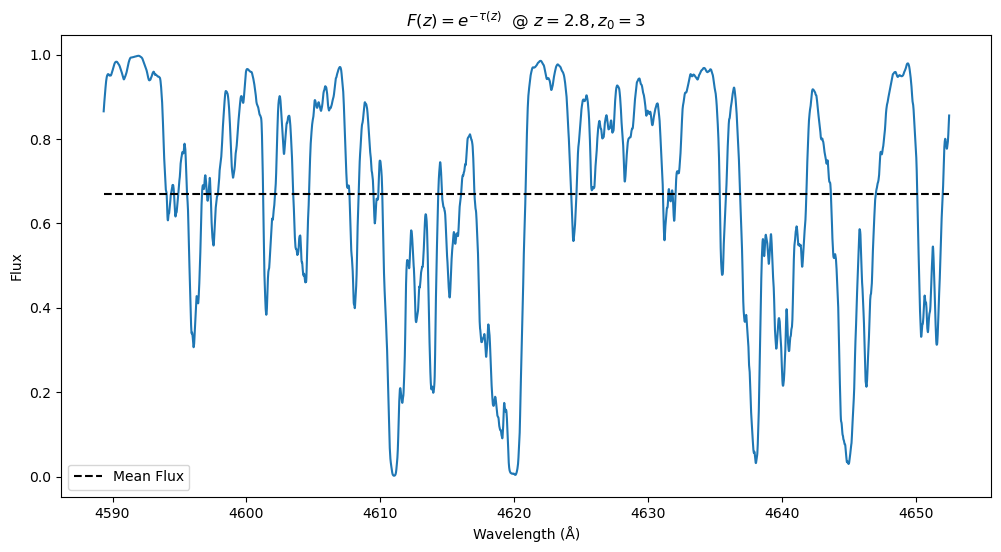

In [29]:
# Generate the wavelength grid
wavelength_field = lambda_c(z=2.8)* (np.exp(velocity_grid / c))

# Calculate optical depth for given redshift
tau_z = optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d), z=2.8)

# Calculate flux
flux_z = flux(tau_z)

# Plot the flux vs wavelength
plt.figure(figsize=(12, 6))
plt.plot(wavelength_field[:10000], flux_z[:10000])  # Use wavelength_field for x-axis and flux_z for y-axis
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.hlines(y=flux_z[:10000].mean(), xmin=wavelength_field[:10000].min(), xmax=wavelength_field[:10000].max(), color='black', ls='--', label='Mean Flux')
plt.legend()
plt.show()

$$ v = c \ln(\lambda/\lambda_{pivot}) $$

/tmp/ipykernel_976477/3217902026.py:20: RuntimeWarning: Mean of empty slice.
  plt.hlines(y=flux_z[min_slice:max_slice].mean(), xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--', label='Mean Flux')
/global/homes/m/mherbold/.conda/envs/lace/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

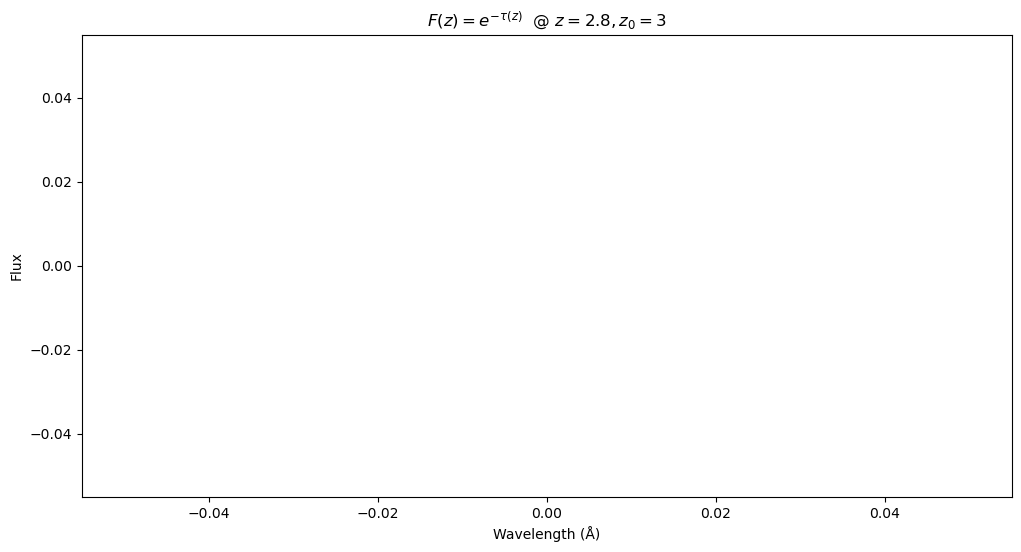

In [30]:
# Generate the wavelength grid
wavelength_field = lambda_c(z=2.8)* (np.exp(velocity_grid / c))

# Calculate optical depth for given redshift
tau_z = optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d), z=2.8)

# Calculate flux
flux_z = flux(tau_z)

# Slice the plots
min_slice = 65000
max_slice = 130000

# Plot the flux vs wavelength
plt.figure(figsize=(12, 6))
plt.plot(wavelength_field[min_slice:max_slice], flux_z[min_slice:max_slice])  # Use wavelength_field for x-axis and flux_z for y-axis
plt.title(r'$ F(z) = e^{-\tau(z)} $  @ $z=2.8, z_0 = 3$')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.hlines(y=flux_z[min_slice:max_slice].mean(), xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--', label='Mean Flux')
plt.legend(loc = 'upper left')
plt.show()

In [32]:
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])

def plot_flux(z):
    # Generate the wavelength grid
    wavelength_field = lambda_c(z) * (np.exp(velocity_grid / c))

    # Calculate optical depth for given redshift
    delta_z = delta_b_v * redshift_evolution(z,z0=3)
    redshifted_variance = variance_1d * redshift_evolution(z,z0=3)**2
    tau_z = optical_depth_transform(lognormal_transform(delta_z, redshifted_variance), z)

    # Calculate flux
    flux_z = flux(tau_z)

    # Plot the flux vs wavelength
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_field[:10000], flux_z[:10000], label='z = '+ str(z))  # Use wavelength_field for x-axis and flux_z for y-axis
    plt.title(r'$ F(z) = e^{-\tau(z)}$')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.hlines(y=flux_z[:10000].mean(), xmin=wavelength_field[:10000].min(), xmax=wavelength_field[:10000].max(), color='black', ls='--', label='Mean Flux')
    plt.legend()
    plt.show()


interact(plot_flux, z = widgets.FloatSlider(value=3,
                                                      min=1.0,
                                                      max=4.2,
                                                      step=0.1))


interactive(children=(FloatSlider(value=3.0, description='z', max=4.2, min=1.0), Output()), _dom_classes=('wid…

<function __main__.plot_flux(z)>

In [ ]:
def plot_flux_array(z, k_field, kmodes, color, dv=1, z0=3):
    # Generate the wavelength grid
    wavelength_field = lambda_c(z) * (np.exp(velocity_grid / c))

    # Calculate optical depth for given redshift
    delta_b_v = delta_transform(k_field, kmodes, dv)
    variance = delta_b_v.var() # sigma^2
    delta_z = delta_b_v * redshift_evolution(z,z0)
    redshifted_variance = variance * redshift_evolution(z,z0)**2
    tau_z = optical_depth_transform(lognormal_transform(delta_z, redshifted_variance), z)

    # Calculate flux
    flux_z = flux(tau_z)

    # Plot the flux vs wavelength
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_field[:10000], flux_z[:10000], label='z = '+ str(z))  # Use wavelength_field for x-axis and flux_z for y-axis
    plt.title(r'$ F(z) = e^{-\tau(z)}$')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.hlines(y=flux_z[:10000].mean(), xmin=wavelength_field[:10000].min(), xmax=wavelength_field[:10000].max(), color='black', ls='--', label='Mean Flux')
    plt.legend()
    plt.show()

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])

norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plot_flux_array(z = z, k_field = gaussian_random_field_k, kmodes = kmodes, dv = 1, z0 = 3, color=color)

# Adjust the legend location
plt.tight_layout()  # Adjust layout to fit everything

plt.rcParams["figure.figsize"] = (7,4)
plt.show()  # Display the plot after all iterations


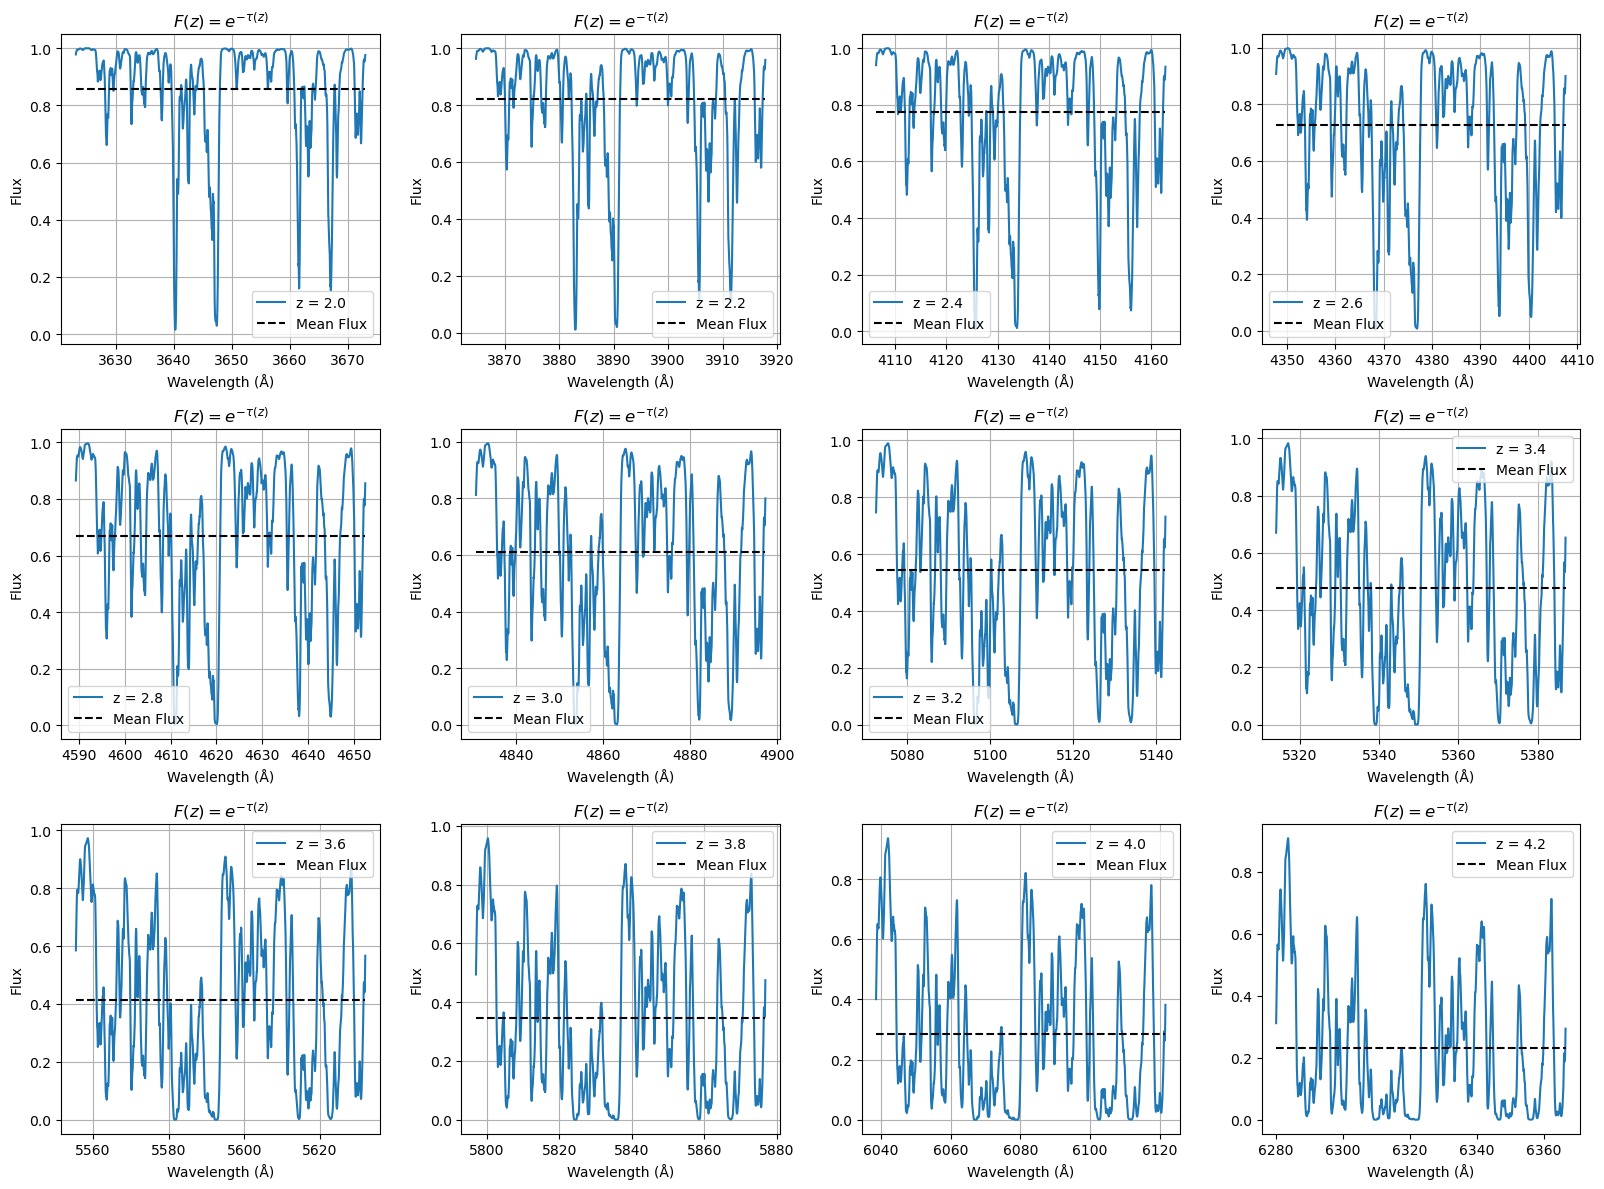

In [31]:
def plot_flux_array(ax, z, k_field, kmodes, color, dv=1, z0=3):
    # Generate the wavelength grid
    wavelength_field = lambda_c(z) * (np.exp(velocity_grid / c))

    # Calculate optical depth for given redshift
    delta_b_v = delta_transform(k_field, kmodes, dv)
    variance = delta_b_v.var()  # sigma^2
    delta_z = delta_b_v * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    tau_z = optical_depth_transform(lognormal_transform(delta_z, redshifted_variance), z)

    # Calculate flux
    flux_z = flux(tau_z)

    # Plot the flux vs wavelength on the given subplot
    ax.plot(wavelength_field[:10000], flux_z[:10000], label=f'z = {z}', color=color)
    ax.set_title(r'$ F(z) = e^{-\tau(z)}$')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.hlines(y=flux_z[:10000].mean(), xmin=wavelength_field[:10000].min(), xmax=wavelength_field[:10000].max(), color='black', ls='--', label='Mean Flux')
    ax.legend()
    ax.grid(True)

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])
norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

# Create subplots with multiple rows and columns (e.g., 3 rows, 4 columns)
nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))
axs = axs.flatten()  # Flatten the grid of subplots for easy iteration

# Loop over zlist and create a plot for each z in its own subplot
for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    # plot_flux_array(ax=axs[i], z=z, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color=color)
    plot_flux_array(ax=axs[i], z=z, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color='tab:blue')

# Remove any unused subplots if zlist doesn't perfectly fill the grid
for j in range(len(zlist), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.grid(False)
plt.show()


### Mean Flux

Them mean flux and power spectrum of these mocks can be analytically computed. Using one-point probability of the base Gaussian random field, $\delta$, we can write down the following integral for the mean flux: 

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

In [34]:
def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)

def x_z(z, variance, z0 = 3):
    x_z = 0.55 * (((1+z)/(1+z0))**5.1) * (np.exp(-((redshift_evolution(z,z0))**2) * variance))
    return(x_z)

def mean_flux(z, variance, z0=3):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)

In [35]:
mean_flux(z=2.8, variance=variance_1d, z0=3)

/tmp/ipykernel_722492/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


0.6737381316528798

In [36]:
test_flux = flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d)))
test_flux.mean()

0.674172772986657

#### Mean Flux vs Redshift

In [37]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])
# z_list = np.array(z_list)

In [38]:
flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
    # flux_list = np.array(flux_list)

/tmp/ipykernel_722492/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


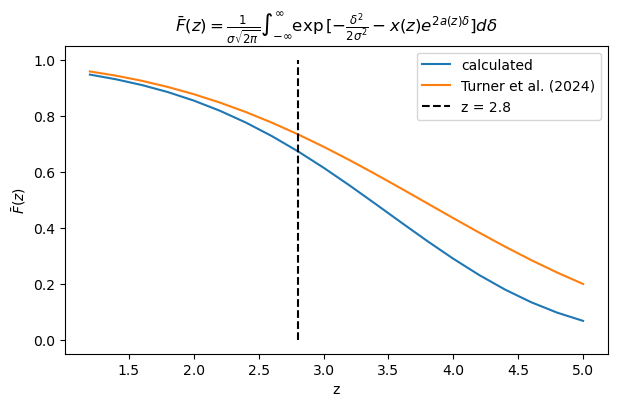

In [39]:
plt.plot(z_list, flux_list, label = 'calculated')

plt.plot(z_list, np.exp(-2.46e-3*(1+z_list)**3.62), label='Turner et al. (2024)')

plt.title(r'$\bar F(z) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty}\exp{[-\frac{\delta^2}{2 \sigma^2}-x(z)e^{2 a(z)\delta}]d\delta}$')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.vlines(x=2.8, ymin=0, ymax=1, ls='--', color = 'black',label='z = 2.8')
plt.legend()
plt.rcParams["figure.figsize"] = (6,4)


### Measure PDF (?)

In [40]:
def pdf(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))
    plt.hist((1 - f_z_vals),
             bins=100, alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
    plt.xlabel('Flux Decrement: D = 1 - F(z)')
    plt.ylabel('PDF weight (D)')
    # plt.title("Histogram with 'auto' bins: F(z=" + str(z) + ", z0=3)")
    # print(flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance))).size)
    
def pdf_f(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))
    plt.hist((f_z_vals),
             bins=100, alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
    plt.xlabel('Flux: F(z)')
    plt.ylabel('PDF weight (F)')  
    

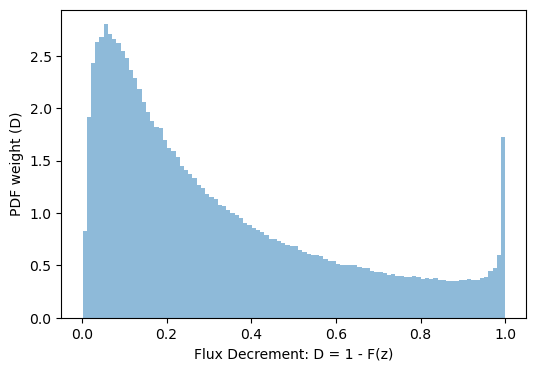

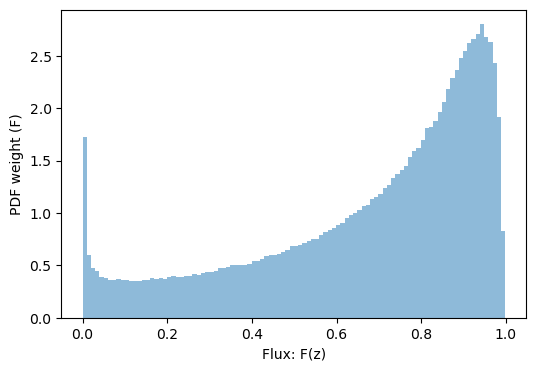

In [41]:
pdf(z=2.8, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color='tab:blue')
plt.show()
pdf_f(z=2.8, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color='tab:blue')
plt.show()

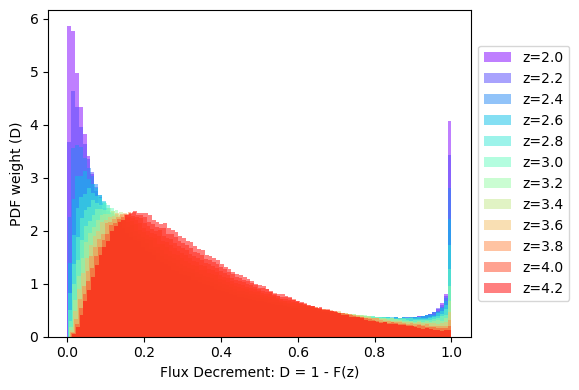

In [42]:
# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])

norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    pdf(z=z, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color=color)

# Adjust the legend location
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))  # Move the legend outside the plot
plt.tight_layout()  # Adjust layout to fit everything

plt.rcParams["figure.figsize"] = (6,4)
plt.show()  # Display the plot after all iterations


## Measure Power

The next test would be to measure the power spectrum, using the ratio of flux / mean flux (analytical), and comparing to the power of the gaussian random field. 

Define flux power spectrum (FPS) as: 

$$ \delta_F \equiv \frac{F - \langle F \rangle}{\langle F \rangle} $$

Where $\langle F \rangle$ is the average flux ($\overline F$)

In [43]:
def delta_F(z,variance,input_flux,z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

def delta_F_k(z,variance,input_flux,z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    delta_f_tilde = np.fft.fft(delta_f)
    return(delta_f_tilde)

In [44]:
delta_f = delta_F(z=2.8, variance=variance_1d, input_flux=test_flux, z0=3)

/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


$$ P_F(k) = \delta_f(k) * \delta_f(k) $$
where $\delta_F(k)$ is the Fourier transform of the flux overdensity.

In [45]:
def P_F(delta_f):
    delta_f_tilde = np.fft.fft(delta_f)
    P_F = np.abs(delta_f_tilde)**2
    return(P_F)

In [46]:
# make a grid of k-modes, using same dims as the field of measured power
# d = spacing of the grid

test_power = P_F(delta_f)
test_power2 = measure_scaled_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3), n=test_power.size, length_scale=1)
kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=1) * 2 * np.pi) + 1e-12 

# print('Number of kmodes: '+ str(kmodes2.size))
# print(kmodes2)

/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


Text(0, 0.5, '$P_F(k)$')

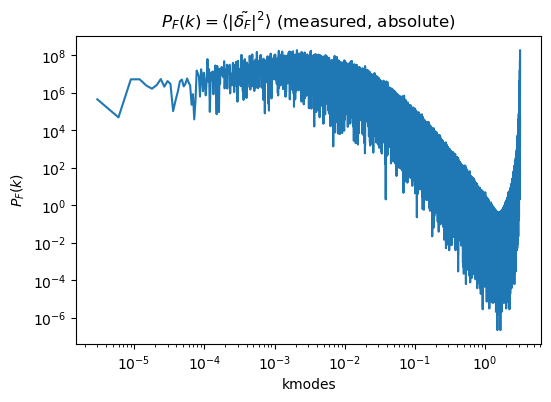

In [47]:
plt.loglog(kmodes2[1:], measure_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3)))
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$ (measured, absolute)')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')

/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


Text(0, 0.5, '$P_F(k)$')

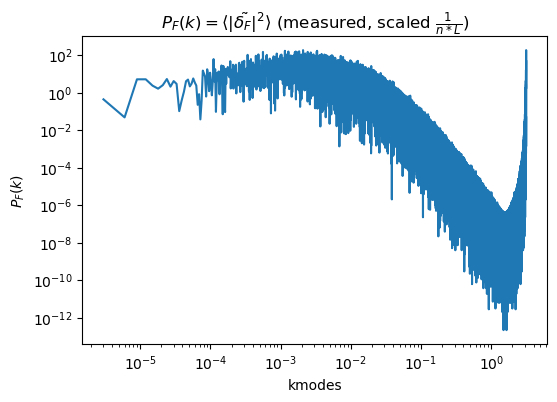

In [48]:
plt.loglog(kmodes2[1:], measure_scaled_power(delta_F_k(z=2.8, input_flux=test_flux, variance=variance_1d, z0=3), n=test_power.size, length_scale=1))
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$ (measured, scaled $\frac{1}{n * L}$)')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')

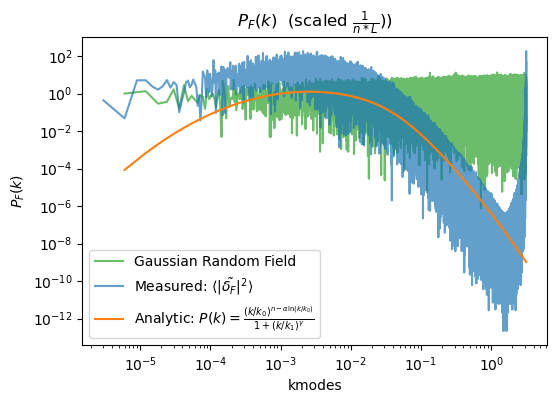

In [49]:
plt.loglog(kmodes[1:], measure_scaled_power(gaussian_random_field_k[1:], n=size, length_scale=1), alpha=0.7, label='Gaussian Random Field', color='tab:green')
plt.loglog(kmodes2[1:], test_power2, label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', alpha=0.7, color='tab:blue')
plt.loglog(kmodes[1:],power_spectrum(kmodes[1:]), label = r'Analytic: $P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$', color='tab:orange')

plt.title(r'$P_F(k)$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')
plt.legend()

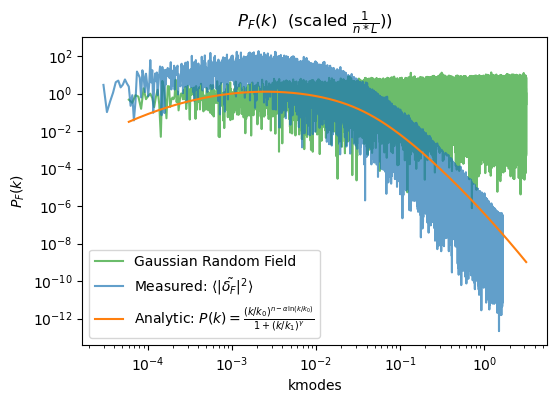

In [50]:
plt.loglog(kmodes[10:548576], measure_scaled_power(gaussian_random_field_k[10:548576], n=size, length_scale=1), alpha=0.7, label='Gaussian Random Field', color='tab:green')
plt.loglog(kmodes2[10:548576], test_power2[10:548576], alpha=0.7, label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', color='tab:blue')
plt.loglog(kmodes[10:548576],power_spectrum(kmodes[10:548576]), label = r'Analytic: $P(k) = \frac{(k / k_0)^{n - \alpha \ln(k/k_0)}}{1 + (k/k_1)^{\gamma}}$', color='tab:orange')

plt.title(r'$P_F(k)$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('kmodes')
plt.ylabel(r'$P_F(k)$')
plt.legend()

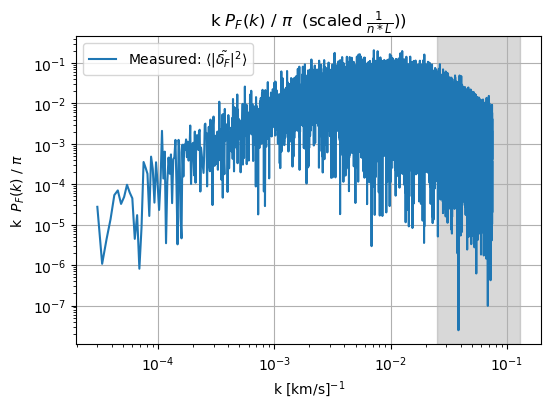

In [51]:
plt.loglog(kmodes2[10:25000], (kmodes2[10:25000]/np.pi)*test_power2[10:25000], label = r'Measured: $\langle | \tilde{\delta_F} |^2 \rangle$', color='tab:blue')

plt.title(r'k $P_F(k)$ / $\pi$  (scaled $\frac{1}{n * L}$))')
plt.xlabel('k [km/s$]^{-1}$')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.legend()
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.rcParams["figure.figsize"] = (9,5)
plt.grid(True)

##### try rebinning

statistic shape:  1000
bin edges shape:  1001
bim number shape: 24990


(0.0001, 0.1)

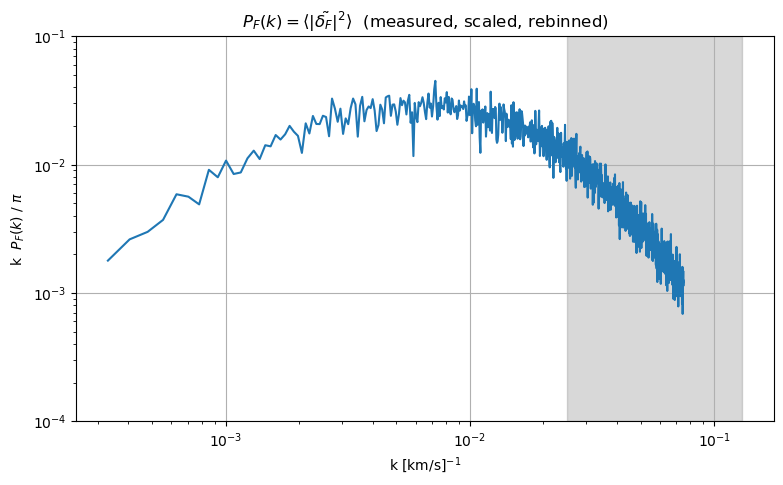

In [52]:
# rebin power normally, then kp/pi first when plot


statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[10:25000], values = 
                                                    test_power2[10:25000], 
                                                    statistic = 'mean', bins=1000)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bim number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                       # in which each value of x belongs. Same length as values 
    
    
    
plt.loglog(bin_edges_test[4:], (bin_edges_test[4:]/np.pi)*statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$  (measured, scaled, rebinned)')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.xlabel('k [km/s$]^{-1}$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.grid(True)
plt.ylim(10e-5,10e-2)

statistic shape:  1000
bin edges shape:  1001
bim number shape: 24990


(0.0001, 0.1)

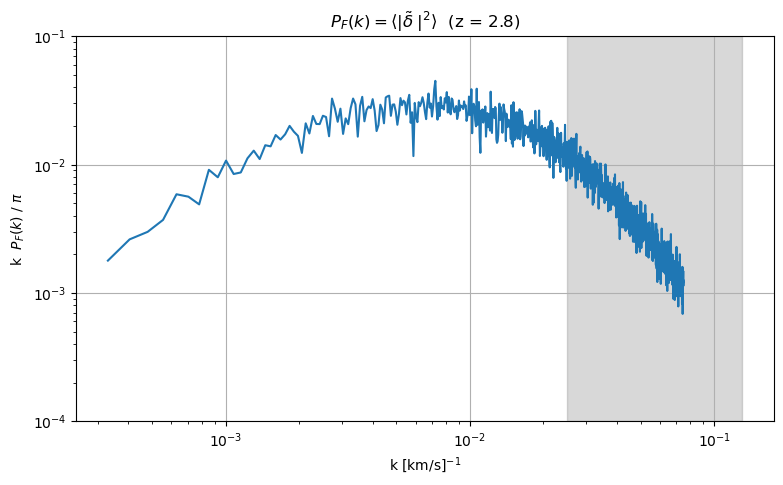

In [53]:
# rescale as kp/pi first when binning, then plot the rebinned data

statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[10:25000], values = 
                                                    test_power2[10:25000], 
                                                    statistic = 'mean', bins=1000)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bim number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                       # in which each value of x belongs. Same length as values 
    
plt.loglog(bin_edges_test[4:], (bin_edges_test[4:]/np.pi)*statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta}_ |^2 \rangle$  (z = 2.8)')
plt.ylabel(r'k  $P_F(k)$ / $\pi$')
plt.xlabel('k [km/s$]^{-1}$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.grid(True)
plt.ylim(10e-5,10e-2)

In [54]:
def plot_power(z, variance, k_field, kmodes, color, dv=1, z0=3): 
    
    delta_b_v = delta_transform(k_field, kmodes, dv)
    variance_1d = delta_b_v.var() # sigma^2
    
    delta_b_z = delta_b_v * redshift_evolution(z,z0)
    redshifted_variance = variance_1d * redshift_evolution(z,z0)**2
    
    test_flux = flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance)))

    delta_f = delta_F(z=z, variance=variance_1d, input_flux=test_flux, z0=z0)
    test_power = P_F(delta_f)
    test_power2 = measure_scaled_power(delta_F_k(z=z0, input_flux=test_flux, variance=variance_1d, z0=z0), n=test_power.size, length_scale=1)
    kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=1) * 2 * np.pi) + 1e-12 

    statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[10:25000], values = 
                                                        test_power2[10:25000], 
                                                        statistic = 'mean', bins=1000)
    
    plt.loglog(bin_edges_test[4:], (bin_edges_test[4:]/np.pi)*statistic_test[3:], label = 'z = ' + str(z), color=color, alpha=0.5)
    plt.title(r'$P_F(k) = \langle | \tilde{\delta}_ |^2 \rangle$')
    plt.ylabel(r'k  $P_F(k)$ / $\pi$')
    plt.xlabel('k [km/s$]^{-1}$')
    plt.rcParams["figure.figsize"] = (9,5)
    # plt.axvspan(0.025, 0.13, alpha=0.1, color='grey')
    plt.grid(True)
    plt.ylim(10e-5,10e-2)

/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


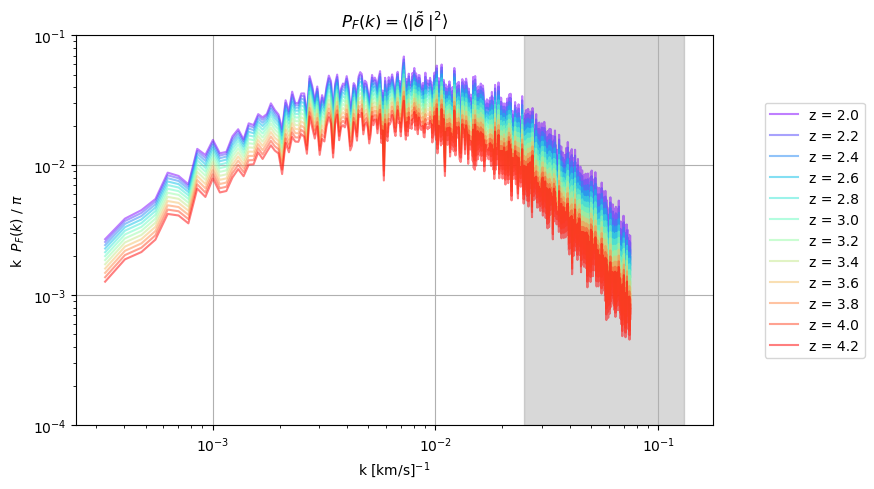

In [55]:
# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])

norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plot_power(z = z, variance = variance_1d, k_field = gaussian_random_field_k, kmodes = kmodes, dv = 1, z0 = 3, color=color)

# Adjust the legend location
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))  # Move the legend outside the plot
plt.axvspan(0.025, 0.13, alpha=0.3, color='grey')
plt.tight_layout()  # Adjust layout to fit everything

plt.rcParams["figure.figsize"] = (7,4)
plt.show()  # Display the plot after all iterations


/tmp/ipykernel_7043/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


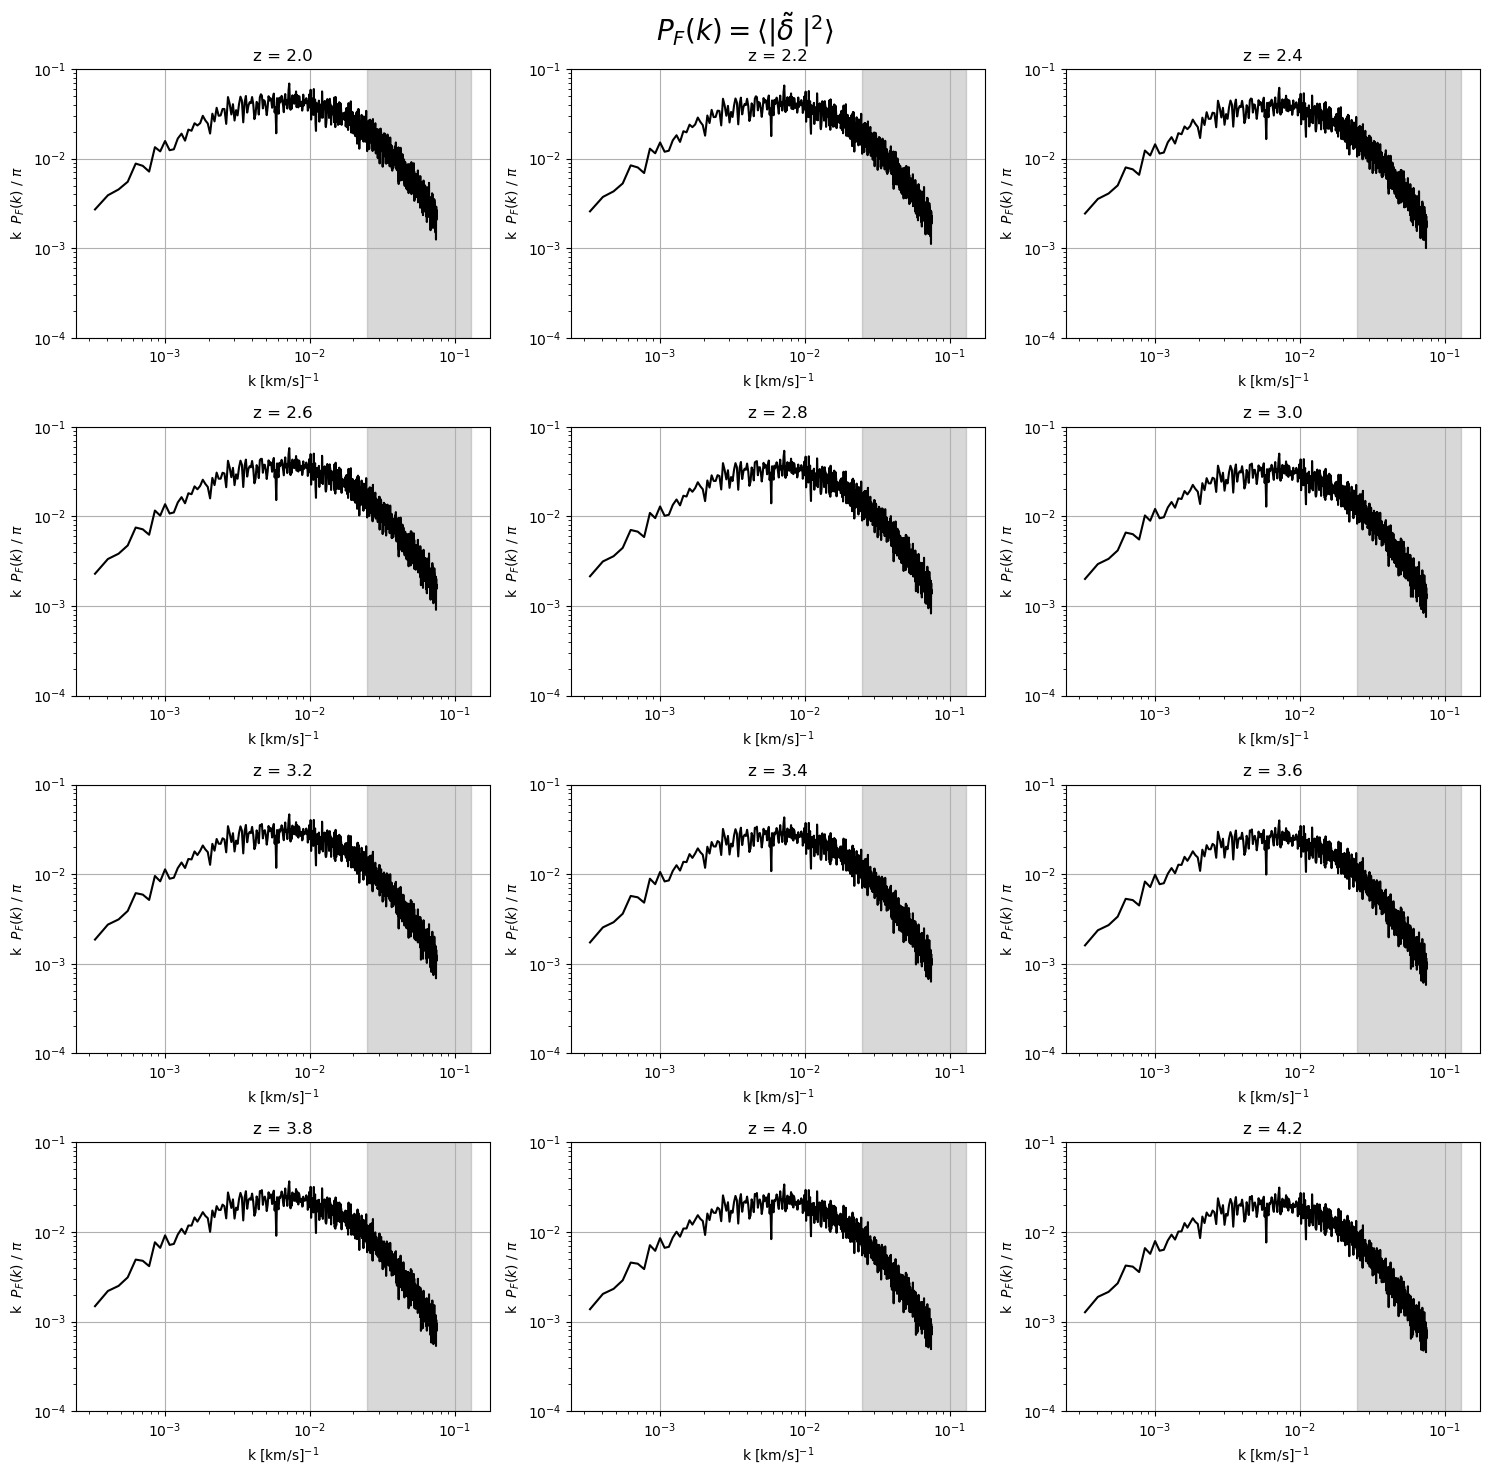

In [56]:
def plot_power_array(ax, z, variance, k_field, kmodes, color, dv=1, z0=3): 
    delta_b_v = delta_transform(k_field, kmodes, dv)
    variance_1d = delta_b_v.var()  # sigma^2
    
    delta_b_z = delta_b_v * redshift_evolution(z, z0)
    redshifted_variance = variance_1d * redshift_evolution(z, z0)**2
    
    test_flux = flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance)))

    delta_f = delta_F(z=z, variance=variance_1d, input_flux=test_flux, z0=z0)
    test_power = P_F(delta_f)
    test_power2 = measure_scaled_power(delta_F_k(z=z0, input_flux=test_flux, variance=variance_1d, z0=z0), n=test_power.size, length_scale=1)
    kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=1) * 2 * np.pi) + 1e-12 

    statistic_test, bin_edges_test, binnumber_test = binned_statistic(
        x=kmodes2[10:25000], values=test_power2[10:25000], 
        statistic='mean', bins=1000)
    
    ax.loglog(bin_edges_test[4:], (bin_edges_test[4:] / np.pi) * statistic_test[3:], 
              label=f'z = {z}', color=color, alpha=1)
    
    ax.axvspan(0.025, 0.13, alpha=0.3, color='grey')  # Vertical shaded region
    ax.set_title(f'z = {z}')
    ax.set_ylabel(r'k  $P_F(k)$ / $\pi$')
    ax.set_xlabel('k [km/s$]^{-1}$')
    ax.grid(True)
    ax.set_ylim(10e-5, 10e-2)

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])
norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

# Create subplots with multiple rows and columns (e.g., 4 rows, 4 columns)
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the grid of subplots for easy iteration


for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plot_power_array(ax=axs[i], z=z, variance=variance_1d, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color='black')
    # plot_power_array(ax=axs[i], z=z, variance=variance_1d, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color=color)

# Remove any empty subplots (if zlist doesn't perfectly fill the grid)
for j in range(len(zlist), len(axs)):
    fig.delaxes(axs[j])

# Add title
fig.suptitle(r'$P_F(k) = \langle | \tilde{\delta}_ |^2 \rangle$', fontsize=20)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Test Gauss-Hermite Quadrature Integration

$$ \int_{-\infty}^{\infty} e^{-x^2}dx \approx \Sigma_{i=1}^n  w_i f(x_i) $$

where, 

$ n = $ number of sample points,

$x_i = $ roots of Hermite Polynomial

$w_i = $ associated weights

#### numpy.polynomial.hermite.hermgauss

Computes the sample points and weights for Gauss-Hermite quadrature. These sample points and weights will correctly integrate polynomials of degree $2 * deg -1$ or less over the interval [-inf, inf], with weight function $f(x) = exp(x^2)$

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

To modify for Gauss-Hermite quadrature: 

$$ I = \int_{-\infty}^{\infty} e^{- \frac{\delta^2}{2 \sigma^2}} \times e^{-x(z)\times e^{2 a(z) \delta}} d\delta$$

$$ I = \int_{-\infty}^{\infty} \exp ( - \frac{\delta^2}{2 \sigma^2} - x(z) \times e^{2 a(z) \delta} )  d\delta $$

Simplify by substituting $\alpha = \frac{1}{2 \sigma^2}$ and $\beta = x(z)$. Then: 

$$ I = \int_{-\infty}^{\infty} \exp(-\alpha \delta^2 - \beta e^{2 a(z)\delta}) d\delta $$

In the Gauss-Hermite quadrature framework, we need the form of $\int_{-\infty}^{\infty} e^{-x^2}f(x)dx$, so we make the changes: 

$$ \delta = \sqrt{2 \sigma^2}x $$

and

$$ d\delta = \sqrt{2 \delta^2}dx $$

then, substituting:

$$ I = \int_{-\infty}^{\infty} \exp(-\frac{(\sqrt{2\sigma^2}x)^2}{2\sigma^2} - \beta e^{2 a(z) \sqrt{2\sigma^2}x})\times \sqrt{2 \sigma^2}x dx$$

$$ I = \sqrt{2 \sigma^2} \int_{-\infty}^{\infty} \exp(-x^2 - \beta e^{2 a(z) \sqrt{2\sigma^2}x}) dx $$

Then, we need to idenltify f(x) for the approximation: 

$$ f(x) = \exp(-\beta e^{2 a(z)\sqrt{2\sigma^2}x}) $$

And in the form of Gauss-Hermite quadrature, we can rewrite the integral: 

$$ \int_{-\infty}^{\infty} e^{x^2} f(x)dx \approx \Sigma_{i=1}^{N}w_i \times f(x_i) $$

becomes:

$$ I \approx \sqrt{2\sigma^2} \Sigma_{i=1}^{N}w_i \times \exp(- \beta e^{2 a(z) \sqrt{2\sigma^2}x_i}) $$

where $x_i$ and $w_i$ are the nodes and weights of for Gauss-Hermite quadrature.

In [40]:
# use the approximation form above, resubmitting the substitution 
# Beta, adding the prefactor, and using n=10

def gh_mean_flux(z, variance, n=10, z0=3, a=58.6, b=-2.82):
    # Parameters
    sigma = np.sqrt(variance_1d)
    a_z = redshift_evolution(z,z0,a,b)
    beta = x_z(z, variance, z0)

    # Number of Gauss-Hermite nodes
    N = n

    # Compute Gauss-Hermite nodes and weights
    nodes, weights = hermgauss(N)

    # Transform nodes for the given problem
    transformed_nodes = np.sqrt(2 * sigma**2) * nodes

    # Compute the function values
    function_values = np.exp(-beta * np.exp(2 * a_z * transformed_nodes))

    # Compute the integral approximation
    integral_approximation = np.sqrt(2 * sigma**2) * np.sum(weights * function_values)

    # multiply by prefactor
    gh_prefactor = 1 / np.sqrt(2 * np.pi * variance)
    integral_approximation = integral_approximation * gh_prefactor
    
    return(integral_approximation)



In [41]:
# Compare to mean flux function: 

print('GH approximation: ' + str(gh_mean_flux(n=10, z=2.8, variance=variance_1d)))
print('Analytic:         ' + str(mean_flux(z=2.8, variance=variance_1d)))
print("Difference:      " + str(np.absolute(gh_mean_flux(n=10, z=2.8, variance=variance_1d)) - mean_flux(z=2.8, variance=variance_1d)))

GH approximation: 0.6736318309321093
Analytic:         0.6737381316528798
Difference:      -0.00010630072077044694


/tmp/ipykernel_722492/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


/tmp/ipykernel_722492/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


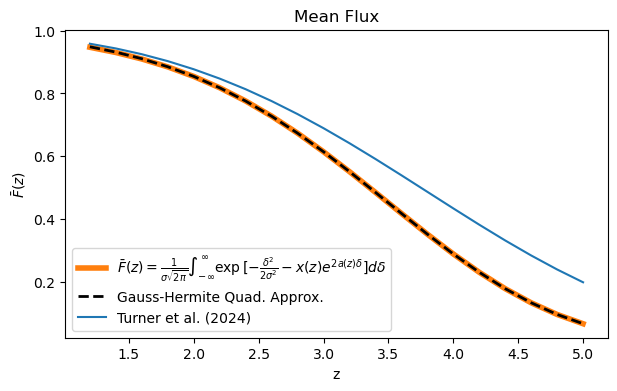

In [42]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

mean_flux_list = []
gh_flux_list = []
difference_list = []
for i in z_list:
    mean_flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
    gh_flux_list.append(gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3))
    difference_list.append(np.absolute(mean_flux(z=i,variance=variance_1d, z0=3) - gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3)))
    
plt.plot(z_list, mean_flux_list, label = r'$\bar F(z) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty}\exp{[-\frac{\delta^2}{2 \sigma^2}-x(z)e^{2 a(z)\delta}]d\delta}$', linewidth=4, color = 'tab:orange')
plt.plot(z_list, gh_flux_list, label = 'Gauss-Hermite Quad. Approx.', ls = '--', linewidth=2, color='black')
plt.plot(z_list, np.exp(-2.46e-3*(1+z_list)**3.62), label='Turner et al. (2024)', color = 'tab:blue')


plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
# plt.vlines(x=2.8, ymin=0, ymax=1, ls='dotted', color = 'black',label='z = 2.8')
plt.legend()
plt.rcParams["figure.figsize"] = (7,4)


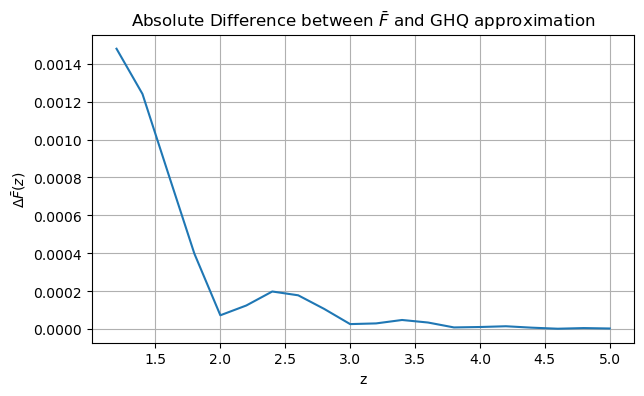

In [43]:
plt.plot(z_list, difference_list)
    
plt.title(r'Absolute Difference between $\bar{F}$ and GHQ approximation')
plt.xlabel('z')
plt.ylabel(r'$\Delta \bar F(z) $')
plt.grid(True)

## Look at correlation functions

First, just test numpy.coorelate: 

numpy.correlate(a,v,mode)is performing the convolution of $a$ with the reverse of $v$ and giving the results clipped by the specified mode.

 - "full" mode returns results for every t where both a and v have some overlap.
 
 - "same" mode returns a result with the same length as the shortest vector (a or v).

 - "valid" mode returns results only when a and v completely overlap each other. The documentation for numpy.convolve gives more detail on the modes.
 
 Documentation: https://numpy.org/doc/stable/reference/generated/numpy.convolve.html

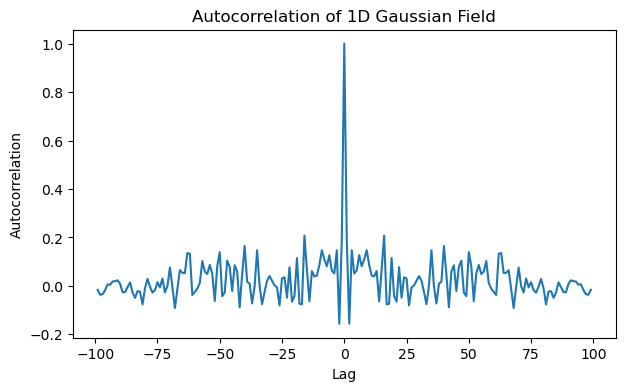

In [44]:
# Generate a 1D Gaussian random field
rng = np.random.default_rng(seed=10)
test_random = rng.normal(size=100)

# Compute the autocorrelation using mode='full'
autocorr = np.correlate(test_random, test_random, mode='full')

# Normalize (optional but common in autocorrelation calculations)
autocorr = autocorr / np.max(autocorr)

# Plot the autocorrelation
import matplotlib.pyplot as plt
lags = np.arange(-len(test_random) + 1, len(test_random))
plt.plot(lags, autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of 1D Gaussian Field")
plt.show()


Text(0, 0.5, 'velocity (km/s)')

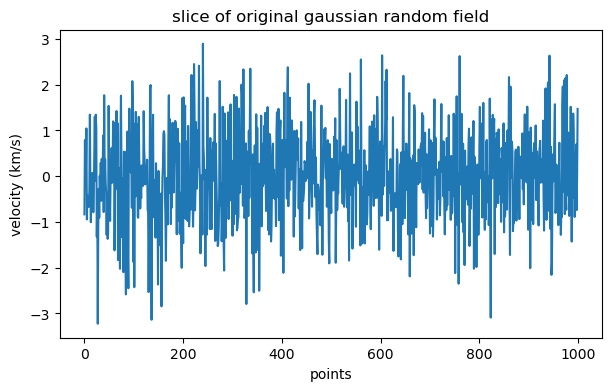

In [131]:
sample_gaussian = gaussian_random_field[1000:2000]
plt.plot(sample_gaussian)
plt.title('slice of original gaussian random field')
plt.xlabel('points')
plt.ylabel('velocity (km/s)')

Text(0, 0.5, 'velocity (km/s)')

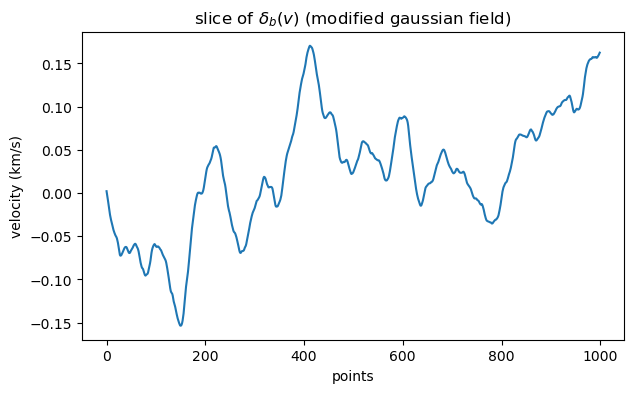

In [130]:
sample_signal = delta_b_v[1000:2000]
plt.plot(sample_signal)
plt.title(r'slice of $\delta_b(v)$ (modified gaussian field)')
plt.xlabel('points')
plt.ylabel('velocity (km/s)')

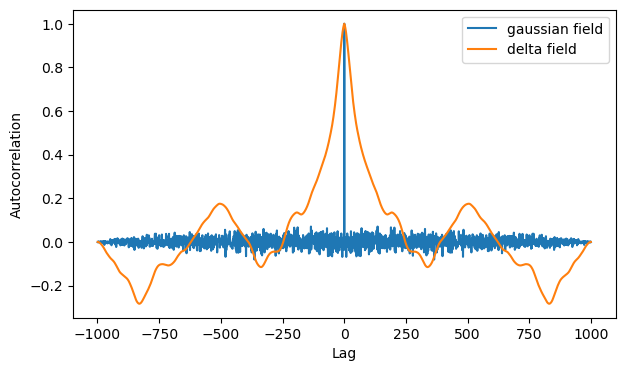

In [132]:
sample_signal = delta_b_v[1000:2000]
sample_gaussian = gaussian_random_field[1000:2000]


# Compute the autocorrelation using mode='full'
autocorr_gauss = np.correlate(sample_gaussian, sample_gaussian, mode='full')
autocorr_signal = np.correlate(sample_signal, sample_signal, mode='full')

# Normalize (optional but common in autocorrelation calculations)
autocorr_gaus = autocorr_gauss / np.max(autocorr_gauss)
autocorr_signal = autocorr_signal / np.max(autocorr_signal)


# Plot the autocorrelation
import matplotlib.pyplot as plt
lags_new = np.arange(-len(sample_gaussian) + 1, len(sample_gaussian))
plt.plot(lags_new, autocorr_gaus, label = 'gaussian field')
plt.plot(lags_new, autocorr_signal, label='delta field')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# plt.title("Autocorrelation of 1D Gaussian Field")
plt.legend()
plt.show()



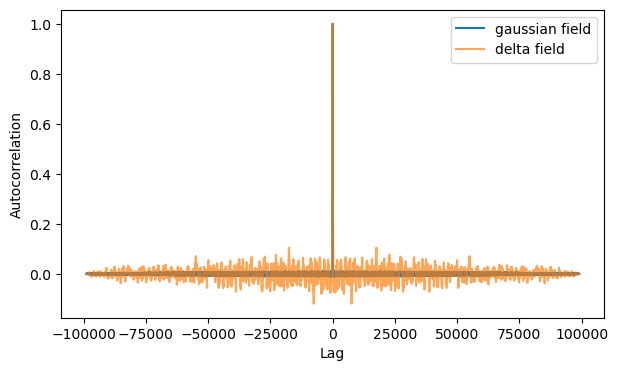

In [139]:
sample_signal = delta_b_v[1000:100000]
sample_gaussian = gaussian_random_field[1000:100000]


# Compute the autocorrelation using mode='full'
autocorr_gauss = np.correlate(sample_gaussian, sample_gaussian, mode='full')
autocorr_signal = np.correlate(sample_signal, sample_signal, mode='full')

# Normalize (optional but common in autocorrelation calculations)
autocorr_gaus = autocorr_gauss / np.max(autocorr_gauss)
autocorr_signal = autocorr_signal / np.max(autocorr_signal)


# Plot the autocorrelation
import matplotlib.pyplot as plt
lags_new = np.arange(-len(sample_gaussian) + 1, len(sample_gaussian))
plt.plot(lags_new, autocorr_gaus, label = 'gaussian field')
plt.plot(lags_new, autocorr_signal, label='delta field', alpha=0.7)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# plt.title("Autocorrelation of 1D Gaussian Field")
plt.legend()
plt.show()



## Try eq. 29 again (goal = correlation function)

$$ 1 + \xi_F(v) = \int e^{-y^2} \frac{1}{\pi\bar{F}(z)} \exp[-x(z)(e^{2a\delta_1}+e^{2a\delta_2})]dy $$

First, define flux fluctuations: 

$$ \delta_F(v,z) = \frac{F(v,z)}{\bar{F}(z)}-1 $$

In [116]:
# Calculate optical depth for given redshift
tau_z = optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance_1d), z=2.8)

# Calculate flux
flux_z = flux(tau_z)

# Calculate mean flux using GHQ
f_bar_gh = gh_mean_flux(z=2.8, variance=variance_1d, z0=3, n=10)

# Calculate flux fluctuations
delta_F = flux_fluctuations(flux_z, f_bar_gh)


Mean Flux: 0.6736318309321093


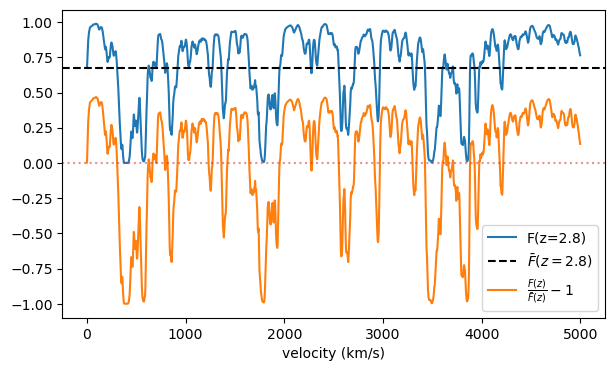

In [122]:
plt.plot(flux_z[5000:10000], label='F(z=2.8)')
# plt.plot(tau_z[:1000], label=r'$\tau(z=2.8)$', alpha=0.5)
plt.axhline([f_bar_gh], color='black', ls='--', label=r'$\bar{F}(z=2.8)$')
plt.plot(delta_F[5000:10000], label=r'$\frac{F(z)}{\bar{F}(z)}-1$')
plt.axhline(0, color='tab:red', ls='dotted', alpha=0.5)
plt.xlabel('velocity (km/s)')
plt.legend()

print('Mean Flux: ' + str(f_bar_gh))

The first version of the equation is: 

\begin{align}
1 + \xi_F(v_{ij}) = \frac{1}{2\pi\sqrt{det{C}}} \int exp[-\delta^T C^{-1} \delta / 2] \left( \frac{F_iF_j}{\bar{F}^2} \right) d\delta  \tag{26}\\
\end{align}

Where, 

\begin{equation} 
C = 
\begin{pmatrix}
  \sigma^2       &    \xi_G(v_{ij})  \\
  \xi_G(v_{ij})       &    \sigma^2  \\
\end{pmatrix}
\tag{27}
\end{equation}

and $\xi_G(v_{ij})$ is the correlation function of the base Gaussian field in 1D. 

To convert this to Gauss-Hermite quadrature with 2 variables, we need to apply Cholesky decomposition: **$C = LL^T$** and transform $\delta = \sqrt{2}L \cdot y$, where:

\begin{equation} 
L = 
\begin{pmatrix}
  \sigma       &    0  \\
  \frac{\xi_G(v)}{\sigma}       &    \sigma\sqrt{1-\frac{\xi_G(v)^2}{\sigma^4}}  \\
\end{pmatrix}
\tag{28}
\end{equation}

and the final expression:

\begin{equation}
1 + \xi_F(v) = \int e^{-y^2} \frac{1}{\pi \bar{F}^2(z)} exp[-x(z)(e^{2 a \delta_1} + e^{2 a \delta_2})] dy \tag{29}
\end{equation}


#### Test of decomposition

In [123]:

# Define the correlation function of the Gaussian field

def xi_G(gaussian_field):
    autocorr_gauss = np.correlate(gaussian_field, gaussian_field, mode='full')
    autocorr_gauss = autocorr_gauss / np.max(autocorr_gauss)
    lags = np.arange(-len(gaussian_field) + 1, len(gaussian_field))
    return autocorr_gauss[len(gaussian_field)//2:]  # Return autocorrelation for non-negative lags

#########################################################

# Cholesky decomposition of covariance matrix for each v

def cholesky_decomp(sigma, xi_G_v):
    # Ensure xi_G_v is not larger than sigma^2
    # if np.abs(xi_G_v) >= sigma**2:
        # print(f"Warning: xi_G_v ({xi_G_v}) is too large compared to sigma^2 ({sigma**2}).")
    
    # Calculate the term inside the square root
    sqrt_term = 1 - (xi_G_v**2 / sigma**4)
    
    # Clamp negative values to zero to avoid sqrt of a negative number
    if sqrt_term < 0:
        # print(f"Warning: sqrt_term ({sqrt_term}) is negative, clamping to zero.")
        sqrt_term = 0
    
    # Perform the Cholesky decomposition
    L = np.array([[sigma, 0],
                  [xi_G_v / sigma, sigma * np.sqrt(sqrt_term)]])
    
    return L

#########################################################

# Generate Gauss-Hermite quadrature points and weights

def gauss_hermite_quadrature(n_points):
    points, weights = np.polynomial.hermite.hermgauss(n_points)
    return points, weights


In [124]:

# Mean flux using GHQ

def gh_mean_flux(z, variance, n=10, z0=3, a=58.6, b=-2.82):
    # Parameters
    sigma = np.sqrt(variance)
    a_z = redshift_evolution(z,z0,a,b)
    beta = x_z(z, variance, z0)

    # Number of Gauss-Hermite nodes = n
    # Compute Gauss-Hermite nodes and weights
    nodes, weights = hermgauss(n)

    # Transform nodes for the given problem
    transformed_nodes = np.sqrt(2 * sigma**2) * nodes

    # Compute the function values
    function_values = np.exp(-beta * np.exp(2 * a_z * transformed_nodes))

    # Compute the integral approximation
    integral_approximation = np.sqrt(2 * sigma**2) * np.sum(weights * function_values)

    # multiply by prefactor
    gh_prefactor = 1 / np.sqrt(2 * np.pi * variance)
    integral_approximation = integral_approximation * gh_prefactor
    
    return(integral_approximation)

# Flux fluctuations

def flux_fluctuations(flux_field, mean_flux):
    return ((flux_field / mean_flux) - 1)


In [125]:

# Final calculation of xi_F(v) with varying xi_G_v

def xi_F(v, delta_F, xi_G_v, sigma, variance, n_points=10, z=2.8, a=0.5):
    
    # Get Cholesky decomposition matrix L
    L = cholesky_decomp(sigma, xi_G_v)
    
    # Gauss-Hermite quadrature points and weights
    points, weights = gauss_hermite_quadrature(n_points)
    
    # Initialize the result (scalar value)
    xi_F_v = 0.0
    
    # Mean flux 
    f_bar = gh_mean_flux(z, variance, z0=3, n=n_points)
    
    # Loop over quadrature points
    for i in range(n_points):
        for j in range(n_points):
            # Compute delta_1 and delta_2 as scalars
            delta_1 = np.sqrt(2) * (L[0, 0] * points[i])  # Scalar
            delta_2 = np.sqrt(2) * (L[1, 0] * points[i] + L[1, 1] * points[j])  # Scalar
            
            # Compute the integrand as a scalar
            integrand = np.exp(-points[i]**2 - points[j]**2) * np.exp(-a * (np.exp(2 * delta_1) + np.exp(2 * delta_2)))
            
            # Accumulate the result
            xi_F_v += weights[i] * weights[j] * integrand / (np.pi * f_bar**2)
    
    # Return the scalar result for this velocity point
    return xi_F_v


In [126]:

# Example usage

sigma = np.sqrt(variance_1d) 
f_bar_gh = gh_mean_flux(z=2.8, variance=variance_1d, z0=3, n=10) 
n_points = 10 # n points for GHQ

# use slice of base gaussian field and corresponding flux (reduce compute time)

xi_G_values = xi_G(delta_b_v[5000:10000])  # Get autocorrelation for all velocity points
v = np.linspace(-1000, 1000, len(xi_G_values))  # Velocity grid (matching the length of xi_G)
delta_F = flux_fluctuations(flux_z[5000:10000], f_bar_gh)

# Calculate xi_F(v) for each velocity point
xi_F_values = [xi_F(v_point, delta_F, xi_G_values[idx], sigma, variance_1d, n_points, z=2.8) for idx, v_point in enumerate(v)]


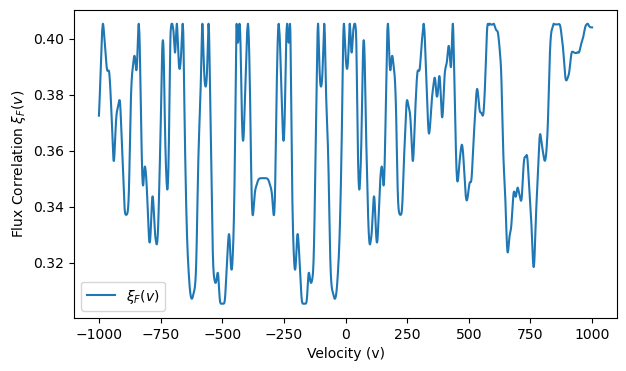

In [127]:

# Plotting the result
plt.plot(v, xi_F_values, label=r'$\xi_F(v)$')
plt.xlabel('Velocity (v)')
plt.ylabel(r'Flux Correlation $\xi_F(v)$')
plt.legend()
plt.show()


#### Measure the power spectrum P(k) from the correlation function (?)

In [142]:
# Example usage (from above)

sigma = np.sqrt(variance_1d) 
f_bar_gh = gh_mean_flux(z=2.8, variance=variance_1d, z0=3, n=10) 
n_points = 10 # n points for GHQ

# use slice of base gaussian field and corresponding flux (reduce compute time)

xi_G_values = xi_G(delta_b_v[1000:10000])  # Get autocorrelation for all velocity points
v = np.linspace(-1000, 1000, len(xi_G_values))  # Velocity grid (matching the length of xi_G)
delta_F = flux_fluctuations(flux_z[1000:10000], f_bar_gh)

# Calculate xi_F(v) for each velocity point
xi_F_values = [xi_F(v_point, delta_F, xi_G_values[idx], sigma, variance_1d, n_points, z=2.8) for idx, v_point in enumerate(v)]


In [144]:
# Assuming xi_G(v) is your correlation function in velocity space
# and v is your velocity array

# Perform Fourier transform of the correlation function
fft_xi_G = np.fft.fft(xi_G_values)

# Compute the corresponding wavenumbers k (in 1D space, k is conjugate to v)
v_spacing = v[1] - v[0]  # Assuming uniform spacing in the velocity grid
k = np.fft.fftfreq(len(v), d=v_spacing) * 2 * np.pi  # Convert to physical wavenumbers

# Power spectrum is proportional to the magnitude squared of the Fourier transform
P_k = np.abs(fft_xi_G)**2

# Optional: Normalize the power spectrum by the number of points
P_k = P_k / len(v)


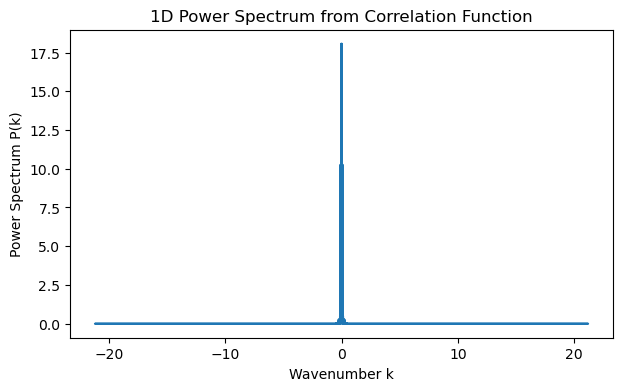

In [145]:
# Plot the 1D power spectrum
plt.plot(k, P_k)
plt.xlabel('Wavenumber k')
plt.ylabel('Power Spectrum P(k)')
plt.title('1D Power Spectrum from Correlation Function')
plt.show()

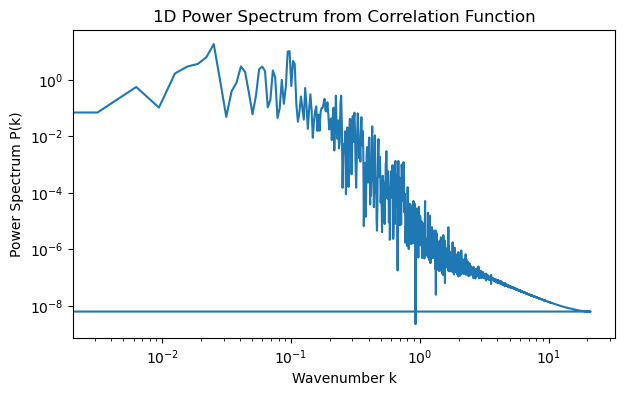

In [146]:
# Plot the 1D power spectrum
plt.loglog(k, P_k)
plt.xlabel('Wavenumber k')
plt.ylabel('Power Spectrum P(k)')
plt.title('1D Power Spectrum from Correlation Function')
plt.show()